In [1]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load, gen_train_input
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
import osmnx as ox
from util import Dataset
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy
from experiment_parameters import *

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:2


In [3]:
# Hyperparam optimized for 10,6
args = {
    'processor':         'GENConv',
    'head':              'regression',     
    'num_layers':        3,
    'num_mlp_layers':    3,
    'aggr':              'max',
    'batch_size':        8,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        32,
    'output_dim':        1,
    'dropout':           0.0306,
    'epochs':            64,
    'opt':               'adagrad',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0121,
    'device':            device,
    'noise':             0 # Set to 0 to not train on noisy features
}

train_loader, val_loader = gen_train_input(BASE_MODEL_TRAIN_CONFIG, args, seed=0)
_, _, _, GNN, _ = train(train_loader, val_loader, args)

In [9]:
save(GNN, args, 'GNN2')

In [ ]:
GNN, args = load('GNN2', device)

## Generalization to larger graphs

In [ ]:
import pickle

num_trials = 150
batch_size = 500

node_configs = EXPERIMENT_SIZE_GENERALIZATION_REGIMES
sizes = [x+y for (x,y) in node_configs]

threshold = 0.35
t_greedy = OBM_Threshold_Greedy(threshold) 


graph_configs = ALL_TESTING_GRAPH_CONFIGS

data = [[] for _ in range(len(graph_configs))]

seed = 0
rng = np.random.default_rng(seed)

for data_index, graph_config in enumerate(graph_configs):
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)

        cr_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )

        t_greedy_ratio, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[t_greedy],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
        )

        cr_ratios['threshold_greedy'] = t_greedy_ratio['learned']

        data[data_index].append(cr_ratios)
    

    with open(f"saved_runs/temp_transferability/transferability_gnn2.pickle", 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
import pickle

with open(f"saved_runs/transferability_gnn2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
import pickle
with open(f"saved_runs/transferability_gnn2.pickle", 'rb') as handle:
    data_copy = pickle.load(handle)

In [53]:
graph_configs = ALL_TESTING_GRAPH_CONFIGS

# To keep only the main graphs
# filtered_data = {}
# for graph_config, val in zip(graph_configs, data_copy):
# 	if graph_config in params.MAIN_TESTING_GRAPH_CONFIGS:
# 		filtered_data[frozenset(graph_config.items())] = val

# To keep all the graphs
filtered_data = {frozenset(g.items()): data for g, data in zip(graph_configs, data_copy)}

dict_keys([frozenset({('p', 0.5), ('graph_type', 'ER'), ('weighted', True)}), frozenset({('weighted', True), ('q', 0.25), ('d', 2), ('graph_type', 'GEOM')}), frozenset({('location', 'Fremont, California, USA'), ('graph_type', 'OSMNX')}), frozenset({('graph_type', 'GM')})])


In [54]:
len(list(filtered_data.values())[0])

15

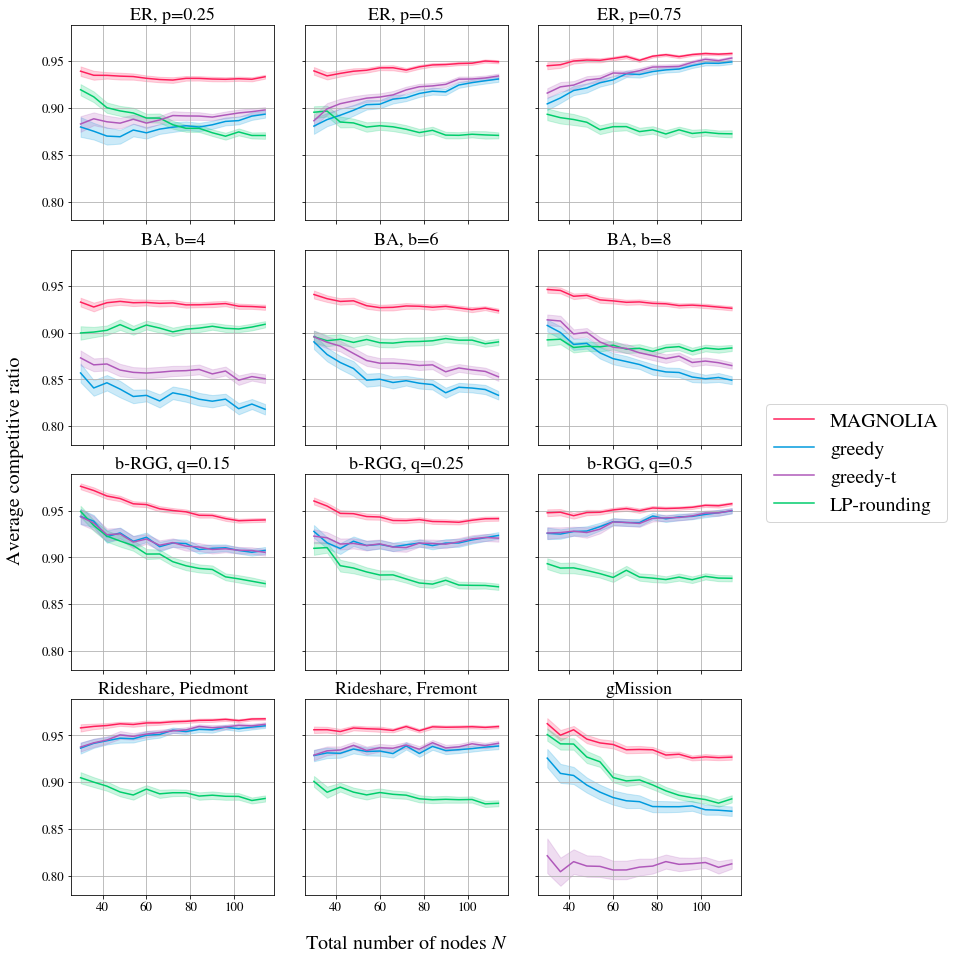

In [61]:
from util import _plot_approx_ratios_all
_plot_approx_ratios_all(sizes, filtered_data, x_axis_name= "Total number of nodes $N$", confidence = 0.95)